In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(15)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.244:60221 Dashboard: http://10.148.0.244:8787/status,Cluster Workers: 10 Cores: 40 Memory: 500.00 GB


___________


In [5]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'

out_dir_mooring = '/home1/scratch/xyu/OSMOSIS_llc4320/mooring_site/cross/'

In [6]:
lat_real_mooring = xr.DataArray([ 48.6875,  48.6940,  48.7480,  48.7000,  48.7485,  48.6803,  48.6290,  48.6780,  48.6290], dims='mooring')
lon_real_mooring = xr.DataArray([-16.1875, -16.1740, -16.0945, -16.2060, -16.2762, -16.1740, -16.0990, -16.2050, -16.2775], dims='mooring')

In [7]:
# C, NE-I,NE-O, NW-I, NW-O, SE-I, SE-O, SW-I, SW-O

inner = 0.0125
outer = 0.075
lat_C = 48.6875
lon_C = -16.1875

# C, N-I,N-O, W-I, W-O, E-I, E-O, S-I, S-O
lat_mooring = xr.DataArray([lat_C, lat_C+inner, lat_C+outer, lat_C,       lat_C,       lat_C,       lat_C,       lat_C-inner, lat_C-outer], dims='mooring')
lon_mooring = xr.DataArray([lon_C, lon_C,       lon_C,       lon_C-inner, lon_C-outer, lon_C+inner, lon_C+outer, lon_C,       lon_C      ], dims='mooring')

# T

In [14]:
ds_T = xr.open_zarr(out_dir_zarr+'Theta_total.zarr')
print(ds_T)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(9415,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [15]:
T_mooring_site = ds_T.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
T_mooring_site = T_mooring_site.drop('dtime')
print(T_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 48.697998 48.710915 48.76255 48.697998 ...
    lon      (mooring) float32 -16.177084 -16.177084 -16.177084 -16.197916 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    Theta    (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(1, 52, 9)>


In [16]:
file_out = out_dir_mooring+'T_mooring.nc'
T_mooring_site.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 3.25 MB detected in task graph: 
  ("('transpose-d33cc5808e9c30b05c858a8fede51f89', 0 ... bdba>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [18]:
ds = xr.open_mfdataset(out_dir_mooring+'T_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
    lon      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    Theta    (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(9415, 52, 9)>

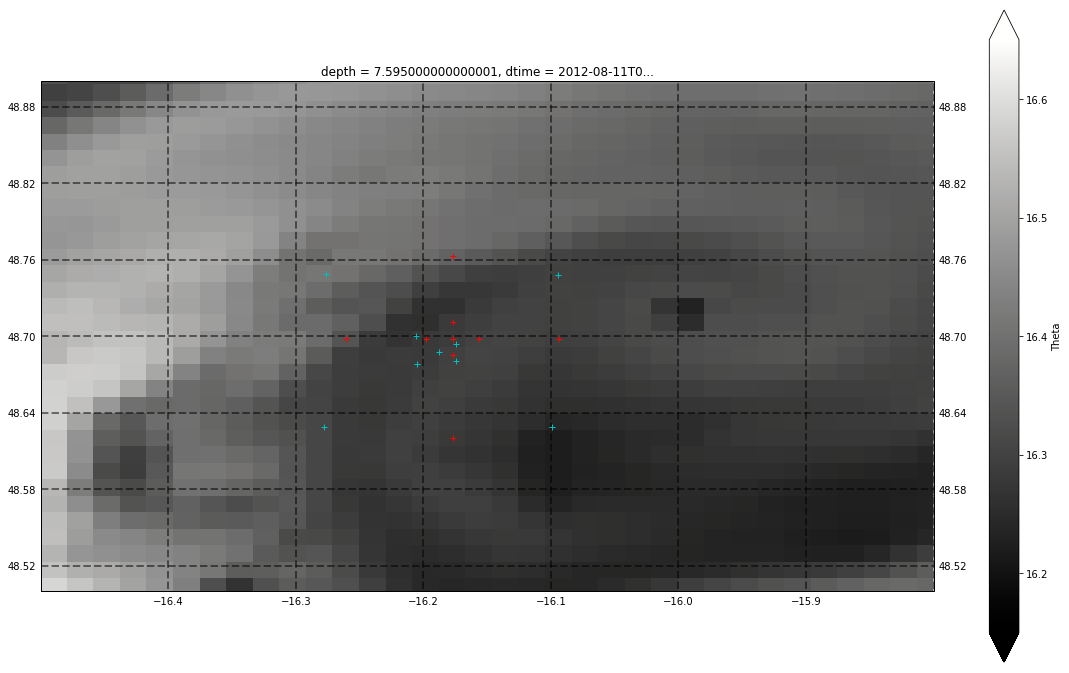

In [19]:
tem = ds_T['Theta'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin= 16.15, vmax=16.65)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'c+')
#ax.plot(T_mooring_site.lon,T_mooring_site.lat, 'r+')
ax.plot(ds.lon,ds.lat, 'r+')

ax.set_xlim([-16.5,-15.8]);
ax.set_ylim([48.5,48.9]);

# S

In [20]:
ds_S = xr.open_zarr(out_dir_zarr+'Salt_total.zarr')
print(ds_S)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(9415,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    Salt     (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [21]:
S_mooring_site = ds_S.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
S_mooring_site = S_mooring_site.drop('dtime')
print(S_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 48.697998 48.710915 48.76255 48.697998 ...
    lon      (mooring) float32 -16.177084 -16.177084 -16.177084 -16.197916 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    Salt     (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(1, 52, 9)>


In [28]:
file_out = out_dir_mooring+'S_mooring.nc'
S_mooring_site.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [29]:
ds = xr.open_mfdataset(out_dir_mooring+'S_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
    lon      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    Salt     (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(9415, 52, 9)>

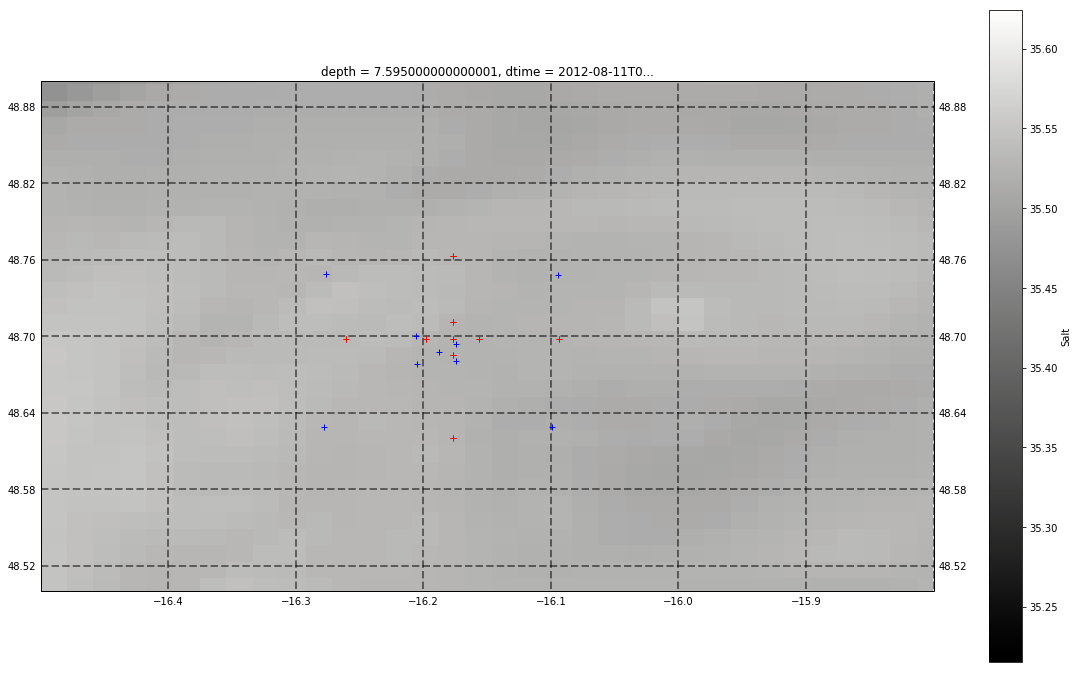

In [30]:
tem = ds_S['Salt'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'b+')
ax.plot(S_mooring_site.lon,S_mooring_site.lat, 'r+')
ax.plot(ds.lon,ds.lat, 'r+')

ax.set_xlim([-16.5,-15.8]);
ax.set_ylim([48.5,48.9]);

# U

In [31]:
ds_U = xr.open_zarr(out_dir_zarr+'U_total.zarr')
ds_U = ds_U.chunk({'depth':52, 'time':1, 'lat':201, 'lon':177})
ds_U = ds_U.drop('dtime')
print(ds_U)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [33]:
U_mooring_site = ds_U.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
#U_mooring_site = U_mooring_site.drop('dtime')
print(U_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 48.697998 48.710915 48.76255 48.697998 ...
    lon      (mooring) float32 -16.177084 -16.177084 -16.177084 -16.197916 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    U        (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(1, 52, 9)>


In [36]:
file_out = out_dir_mooring+'U_mooring.nc'
U_mooring_site.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [38]:
ds = xr.open_mfdataset(out_dir_mooring+'U_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
    lon      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    U        (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(9415, 52, 9)>

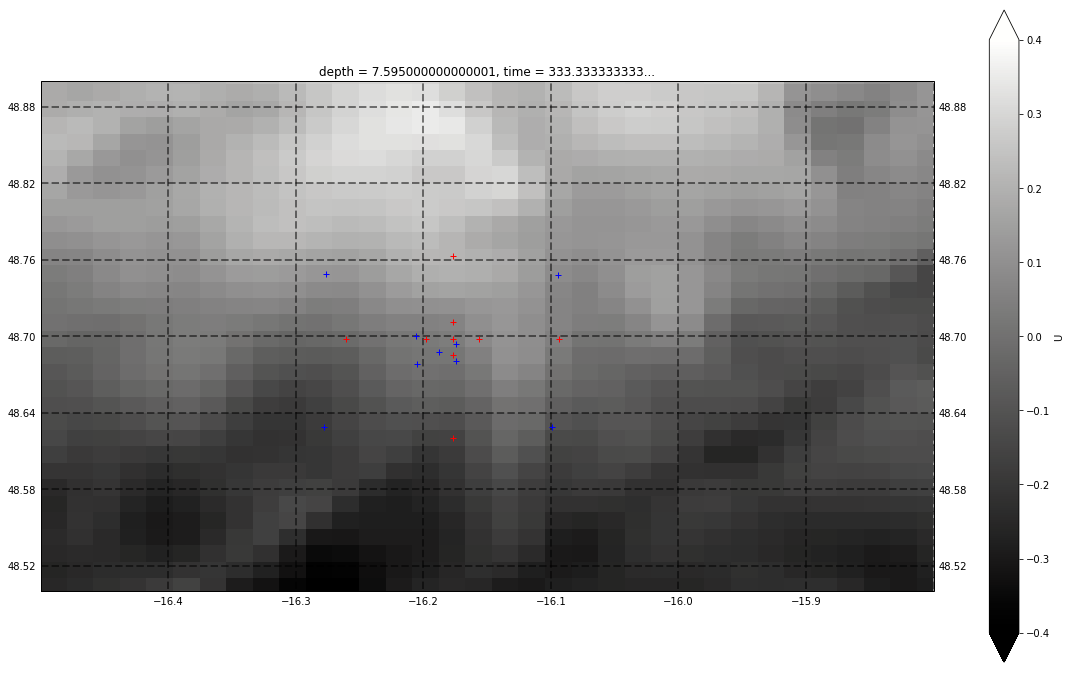

In [39]:
tem = ds_U['U'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin=-0.4, vmax=0.4)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'b+')
#ax.plot(U_mooring_site.lon,U_mooring_site.lat, 'r+')

ax.plot(ds.lon,ds.lat, 'r+')


ax.set_xlim([-16.5,-15.8]);
ax.set_ylim([48.5,48.9]);

# V

In [40]:
ds_V = xr.open_zarr(out_dir_zarr+'V_total.zarr')
ds_V = ds_V.chunk({'depth':52, 'time':1, 'lat':201, 'lon':177})
ds_V = ds_V.drop('dtime')
print(ds_V)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [42]:
V_mooring_site = ds_V.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
#V_mooring_site = V_mooring_site.drop('dtime')
print(V_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 48.697998 48.710915 48.76255 48.697998 ...
    lon      (mooring) float32 -16.177084 -16.177084 -16.177084 -16.197916 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    V        (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(1, 52, 9)>


In [43]:
file_out = out_dir_mooring+'V_mooring.nc'
V_mooring_site.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [45]:
ds = xr.open_mfdataset(out_dir_mooring+'V_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
    lon      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    V        (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(9415, 52, 9)>

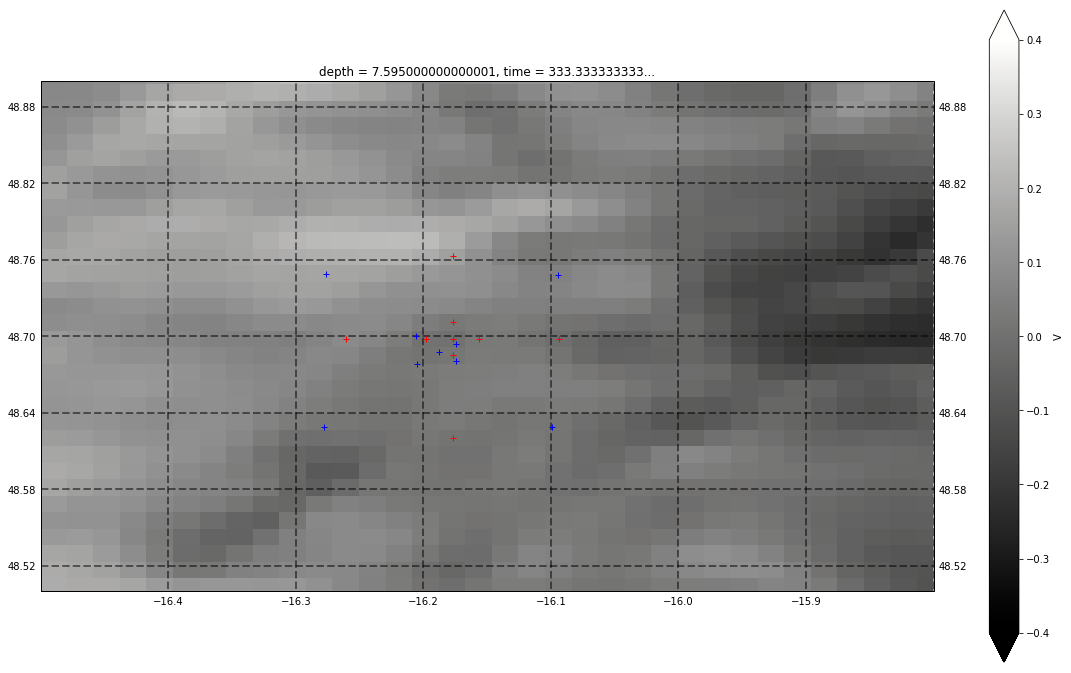

In [46]:
tem = ds_V['V'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin=-0.4, vmax=0.4)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'b+')
ax.plot(ds.lon,ds.lat, 'r+')

ax.set_xlim([-16.5,-15.8]);
ax.set_ylim([48.5,48.9]);

# W

In [47]:
ds_W = xr.open_zarr(out_dir_zarr+'W_total.zarr')
ds_W = ds_W.chunk({'depth':52, 'time':1, 'lat':201, 'lon':177})
ds_W = ds_W.drop('dtime')

print(ds_W)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    W        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [48]:
W_mooring_site = ds_W.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
#W_mooring_site = W_mooring_site.drop('dtime')
print(W_mooring_site)

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 48.697998 48.710915 48.76255 48.697998 ...
    lon      (mooring) float32 -16.177084 -16.177084 -16.177084 -16.197916 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    W        (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(1, 52, 9)>


In [49]:
file_out = out_dir_mooring+'W_mooring.nc'
W_mooring_site.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [50]:
ds = xr.open_mfdataset(out_dir_mooring+'W_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
    lon      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    W        (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(9415, 52, 9)>

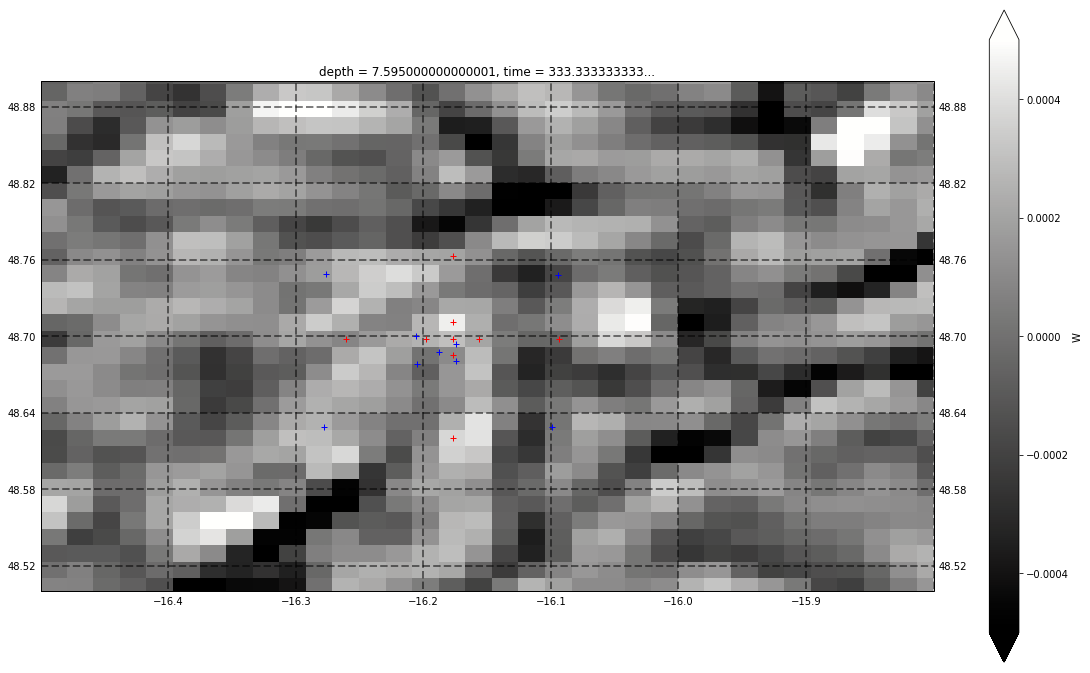

In [51]:
#tem = ds_V['V'].isel(depth=5,time=8000) 
tem = ds_W['W'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin=-0.0005, vmax=0.0005)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'b+')
ax.plot(ds.lon,ds.lat, 'r+')

ax.set_xlim([-16.5,-15.8]);
ax.set_ylim([48.5,48.9]);

# KPPhbl

In [8]:
ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl_total.zarr')
ds_KPP = ds_KPP.chunk({'time':1, 'lat':201, 'lon':177})

print(ds_KPP)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    KPPhbl   (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(1, 201, 177)>


In [9]:
KPP_mooring_site = ds_KPP.sel(lat=lat_mooring, lon=lon_mooring, method='backfill')
print(KPP_mooring_site)

<xarray.Dataset>
Dimensions:  (mooring: 9, time: 9415)
Coordinates:
    lat      (mooring) float32 48.697998 48.710915 48.76255 48.697998 ...
    lon      (mooring) float32 -16.177084 -16.177084 -16.177084 -16.197916 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    KPPhbl   (time, mooring) float32 dask.array<shape=(9415, 9), chunksize=(1, 9)>


In [10]:
file_out = out_dir_mooring+'KPP_mooring.nc'
KPP_mooring_site.to_netcdf(file_out, mode='w')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 2.87 MB detected in task graph: 
  ("('transpose-a4b916630b01787f2b491343309a0239', 0 ... 9f6b>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [11]:
ds = xr.open_mfdataset(out_dir_mooring+'KPP_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (mooring: 9, time: 9415)
Coordinates:
    lat      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
    lon      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Dimensions without coordinates: mooring
Data variables:
    KPPhbl   (time, mooring) float32 dask.array<shape=(9415, 9), chunksize=(9415, 9)>

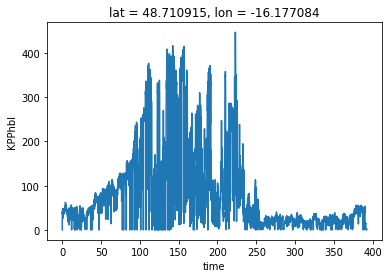

In [12]:
ds['KPPhbl'].isel(mooring=1).plot()

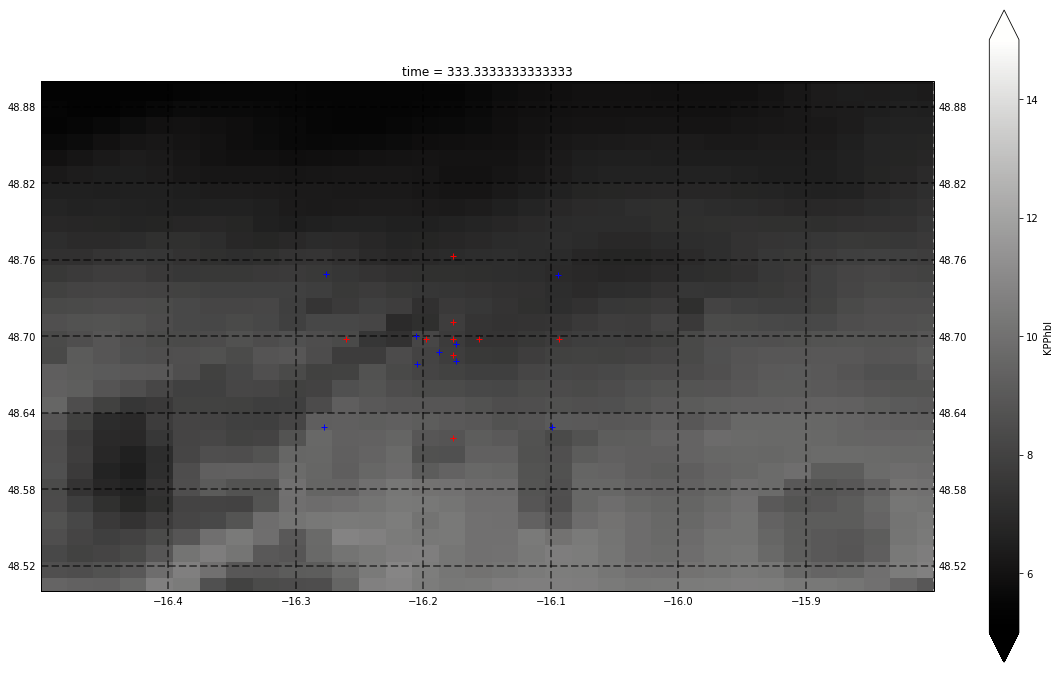

In [19]:
#tem = ds_V['V'].isel(depth=5,time=8000) 
tem = ds_KPP['KPPhbl'].isel(time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin=5, vmax=15)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'b+')
ax.plot(ds.lon,ds.lat, 'r+')

ax.set_xlim([-16.5,-15.8]);
ax.set_ylim([48.5,48.9]);

In [21]:
cluster.scheduler.close()

<Future finished result=None>